In [34]:
### IMPORTS 

import warnings
warnings.filterwarnings("ignore")

import os
import requests as r 
import itertools

import pandas as pd
import numpy as np

import datetime as dt
from dateutil.parser import parse

import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from functools import reduce

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

sns.set()
pd.set_option('display.max_colwidth', None)


In [3]:
from IPython.display import display, HTML

css = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(css))

# Retrieve Data From IMF 

In [4]:
def retrieve_dataset(series:str, frequency:str, area:str, indicator:str, unit:str):
    """
    This function retrieves data from IMF dataservices API
    
    series: The series code 
    frequency: The dataset frequency
    area: The data region
    indicator: The Indicator code
    unit: The data measurement unit
    """

    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
    key = f'CompactData/{series}/{frequency}.{area}.{indicator}.{unit}'
    
    data = r.get(f'{url}{key}').json()
    
    tmp = data['CompactData']['DataSet']['Series']

    df = pd.DataFrame({tmp['@COMMODITY'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
         round(float(i['@OBS_VALUE']), 2) for i in tmp['Obs']}})
       
    return df 

copper_ = {
    'series': "PCPS",
    'frequency': "M",
    'area': "W00",
    'indicator': "PCOPP",
    'unit': "USD"
}

oil_ = {
    'series': "PCPS",
    'frequency': "M",
    'area': "W00",
    'indicator': "POILBRE",
    'unit': "USD"
}


df_copper = retrieve_dataset(copper_['series'],
                             copper_['frequency'],
                             copper_['area'],
                             copper_['indicator'],
                             copper_['unit'])

df_oil = retrieve_dataset(oil_['series'],
                             oil_['frequency'],
                             oil_['area'],
                             oil_['indicator'],
                             oil_['unit'])

print('\nCOPPER')
print(df_copper.info())

print('\nOIL')
print(df_oil.info())


COPPER
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 1990-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PCOPP   373 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None

OIL
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 1990-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POILBRE  373 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None


In [30]:
df = pd.merge(df_copper, df_oil, how='inner', right_index=True, left_index=True)

col_map = {
    "PCOPP": 'COPPER_USD_TON',
    "POILBRE": 'BRENT_OIL_USD_BLL'
}

df = df.rename(columns=col_map)

df.reset_index()

index  COPPER_USD_TON  BRENT_OIL_USD_BLL
0   1990-01-01         2365.56              21.25
1   1990-02-01         2358.94              19.93
2   1990-03-01         2625.70              18.37
3   1990-04-01         2685.23              16.49
4   1990-05-01         2740.34              16.34
..         ...             ...                ...
368 2020-09-01         6704.90              41.09
369 2020-10-01         6713.81              40.47
370 2020-11-01         7068.91              43.22
371 2020-12-01         7772.24              49.85
372 2021-01-01         7972.15              54.55

[373 rows x 3 columns]

# Model Building 

In [5]:
def mae(residuals):
    return np.mean(np.abs(residuals))

def rmse(residuals):
    return np.sqrt(np.mean(residuals)**2)

def mape(y, yhat):
    abs_diff = np.abs(y-yhat)
    ape = abs_diff/np.abs(y)
    ape[ape == np.inf] = 0
    ape[ape == np.nan] = 0 
    return np.mean(ape)*100

In [64]:
def optimize_ARIMA(ts, order:tuple):
    
    p,d,q = order

    model_selection = []

    aic_matrix = []
    bic_matrix = []

    for p in range(p+1):
        aic_tmp = []
        bic_tmp = []

        for q in range(q+1):
            model = ARIMA(ts, order=(p, d, q))
            results = model.fit()
            model_selection.append((p,q, results.aic, results.bic))
            aic_tmp.append(results.aic)
            bic_tmp.append(results.bic)

        aic_matrix.append(aic_tmp)
        bic_matrix.append(bic_tmp)

    aic_matrix = np.matrix(aic_matrix).reshape(p+1,q+1)
    bic_matrix = np.matrix(bic_matrix).reshape(p+1,q+1)
    model_selection = pd.DataFrame(model_selection, columns=['p','q', 'aic', 'bic'])
    
    return aic_matrix, bic_matrix, model_selection


def minimize_params(thld, results):
    
    order = results[0]
    
    for i, (k, v) in enumerate(thld.items()):
        
        best = v[1]
        metric = results[i+1]
        
        if metric < best:
            thld[k] = [results[0], metric]
        else:
            continue 
            
    return thld
            

def gridsearch_ARIMA(ts, order, verbose=False):
    """
    
    This is a helper function to gridsearch arima order 
    params.
    
    
    :param ts: 
    :param order:
    :param verbose:
    :return: 
    
    """
    
    p,d,q = order

    classes = list(itertools.product(range(p+1), range(d+1), range(q+1)))
    
    model_selection = []
    
    best = {
        "AIC": [classes[0], np.inf],
        "BIC": [classes[0], np.inf],
        "MAE": [classes[0], np.inf],
        "RMSE": [classes[0], np.inf]
    }
    
    for param in classes:
 
        try:
            model = ARIMA(ts, order=param).fit()
            results = (param, model.aic, model.bic, mae(model.resid), rmse(model.resid))
            best = minimize_params(best, results)
            model_selection.append(results)
            if verbose:
                print(f"ARIMA{param} - AIC:{model.aic} BIC:{model.bic} MAE:{mae(model.resid)} RMSE: {rmse(model.resid)}")
        except:
            continue 
            
    model_selection = pd.DataFrame(model_selection,
                                   columns = ['order', 'aic', 'bic', 'mae', 'rmse'])
    
    best = pd.DataFrame(best)\
    .T\
    .rename(
        columns={0: 'ARIMA(p,d,q)',
                 1: 'metric_value'})
    
    return best, model_selection


def model_diagnostics(ts, model_order, figure=(16,8)):
    
    model = ARIMA(ts, order=model_order)
    results = model.fit()
    
    print(f"ARIMA{model_order} MAE: {mae(results.resid)}")
    print(f"ARIMA{model_order} MAPE: {mape(ts, results.fittedvalues)}")

    fig1 = plt.figure(figsize=figure)
    fig1.suptitle(f"AIC MODEL ARIMA{model_order} DIAGNOSTICS")
    
    results.plot_diagnostics(fig=fig1)
    
    return results    

## COPPER

## MODEL BUILDING 

**COPPER**

* Série não-estacionária: DIFF(1)
* ACF e PACF série diferenciada (estacionária)
    - ACF: Cuts-off @ k=1
    - PACF: Cuts-off @ k=1
    
* ARIMA(p,q,d):
    - ARIMA(1,1,0) - pure AR
    - ARIMA(0,1,1) - pure MA
    - ARIMA(1,1,1)
    - p=2 e/ou q=2

In [31]:
df.COPPER_USD_TON.head()

1990-01-01    2365.56
1990-02-01    2358.94
1990-03-01    2625.70
1990-04-01    2685.23
1990-05-01    2740.34
Name: COPPER_USD_TON, dtype: float64

In [42]:
copper_best, copper_models = gridsearch_ARIMA(df.COPPER_USD_TON, (2,1,2), verbose=True)

copper_best

ARIMA(0, 0, 0) - AIC:6880.7053928457535 BIC:6888.5485496850415 MAE:2243.929692704053 RMSE: 0.0015188059510523328
ARIMA(0, 0, 1) - AIC:6452.568319245186 BIC:6464.333054504117 MAE:1196.5741760124813 RMSE: 3.645352719089949
ARIMA(0, 0, 2) - AIC:6082.243474080931 BIC:6097.929787759506 MAE:724.6878293225058 RMSE: 1.2792743508679507
ARIMA(0, 1, 0) - AIC:5348.232907439483 BIC:5352.151801293756 MAE:203.73718498659517 RMSE: 21.373056300268093
ARIMA(0, 1, 1) - AIC:5306.938471263891 BIC:5314.776258972437 MAE:192.07524042131925 RMSE: 17.5984716661041
ARIMA(0, 1, 2) - AIC:5304.568468528356 BIC:5316.325150091176 MAE:191.4649239137267 RMSE: 16.479500504426074
ARIMA(1, 0, 0) - AIC:5369.472362436789 BIC:5381.23709769572 MAE:202.75989978557206 RMSE: 9.573668888980949
ARIMA(1, 0, 1) - AIC:5327.136014663007 BIC:5342.822328341582 MAE:191.60183873573567 RMSE: 5.907993987437209
ARIMA(1, 0, 2) - AIC:5324.271561697782 BIC:5343.879453796001 MAE:190.90593134334745 RMSE: 4.807645427542211
ARIMA(1, 1, 0) - AIC:530

ARIMA(p,d,q) metric_value
AIC     (1, 1, 0)       5303.2
BIC     (1, 1, 0)      5311.04
MAE     (1, 0, 2)      190.906
RMSE    (0, 0, 0)   0.00151881

In [46]:
copper_models.head()

order          aic          bic          mae       rmse
0  (0, 0, 0)  6880.705393  6888.548550  2243.929693   0.001519
1  (0, 0, 1)  6452.568319  6464.333055  1196.574176   3.645353
2  (0, 0, 2)  6082.243474  6097.929788   724.687829   1.279274
3  (0, 1, 0)  5348.232907  5352.151801   203.737185  21.373056
4  (0, 1, 1)  5306.938471  5314.776259   192.075240  17.598472

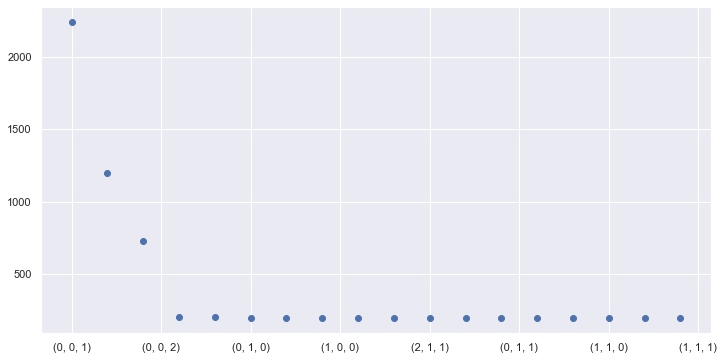

order          aic          bic          mae       rmse
0   (0, 0, 0)  6880.705393  6888.548550  2243.929693   0.001519
1   (0, 0, 1)  6452.568319  6464.333055  1196.574176   3.645353
2   (0, 0, 2)  6082.243474  6097.929788   724.687829   1.279274
3   (0, 1, 0)  5348.232907  5352.151801   203.737185  21.373056
6   (1, 0, 0)  5369.472362  5381.237098   202.759900   9.573669
16  (2, 1, 1)  5304.094056  5319.769632   192.259208  20.531324
4   (0, 1, 1)  5306.938471  5314.776259   192.075240  17.598472
9   (1, 1, 0)  5303.204558  5311.042346   191.888382  16.182818
10  (1, 1, 1)  5305.035455  5316.792137   191.796558  16.333117
15  (2, 1, 0)  5304.978514  5316.735195   191.766445  16.384826
7   (1, 0, 1)  5327.136015  5342.822328   191.601839   5.907994
11  (1, 1, 2)  5306.536168  5322.211743   191.526331  16.412452
5   (0, 1, 2)  5304.568469  5316.325150   191.464924  16.479501
17  (2, 1, 2)  5307.983015  5327.577484   191.377722  16.785854
12  (2, 0, 0)  5322.747189  5338.433503   191.230985   4.479830
13  (2, 0, 1)  5324.645326  5344.253218   191.201429   4.594446
14  (2, 0, 2)  5326.225624  5349.755095   191.022099   4.697164
8   (1, 0, 2)  5324.271562  5343.879454   190.905931   4.807645

In [61]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.scatter(
    x=copper_models.sort_values('mae', ascending=False).reset_index().index,
    y=copper_models.sort_values('mae', ascending=False).reset_index().mae
)

ax1.set_xticklabels(copper_models.sort_values('mae', ascending=False).reset_index().order.values)

plt.show()

copper_models.sort_values('mae', ascending=False)

ARIMA(1, 1, 0) MAE: 191.88838228033566
ARIMA(1, 1, 0) MAPE: 4.330371689567702


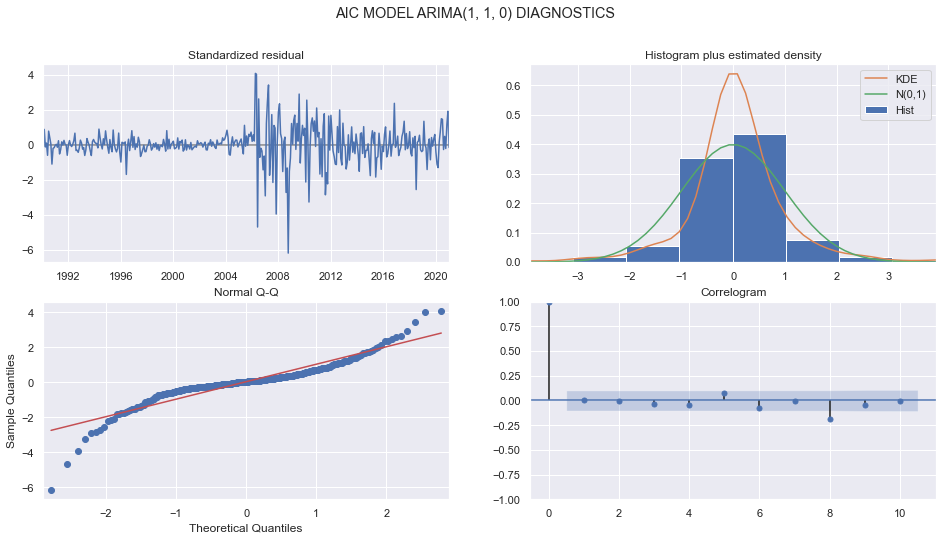

In [65]:
cpr_ic_result = model_diagnostics(df.COPPER_USD_TON, (1,1,0))

ARIMA(2, 1, 2) MAE: 191.3777222532441
ARIMA(2, 1, 2) MAPE: 4.3192974745353645


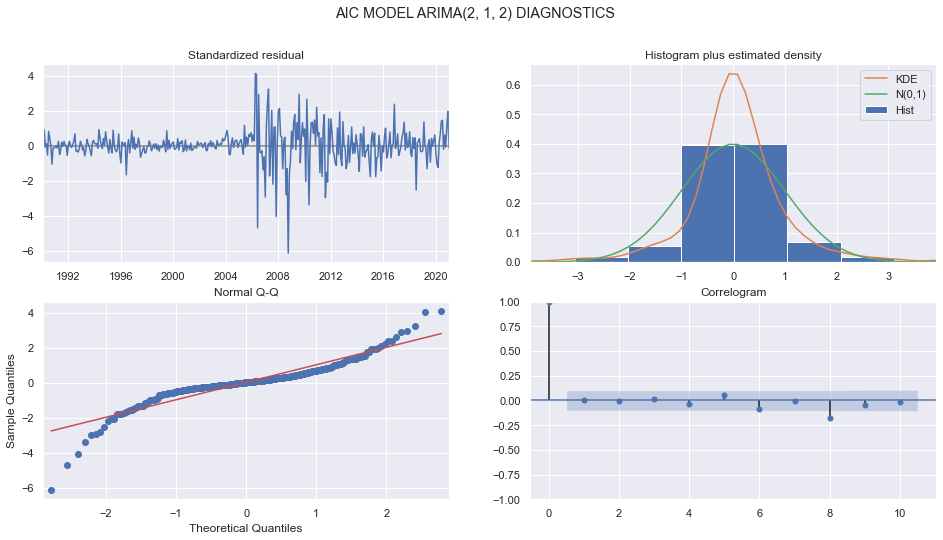

In [71]:
cpr_mae_result = model_diagnostics(df.COPPER_USD_TON, (2,1,2))

ARIMA(1, 1, 0) MAE: 191.88838228033566
ARIMA(1, 1, 0) MAPE: 4.073195269378369
ARIMA(2, 1, 2) MAE: 191.3777222532441
ARIMA(2, 1, 2) MAPE: 4.062091284950782


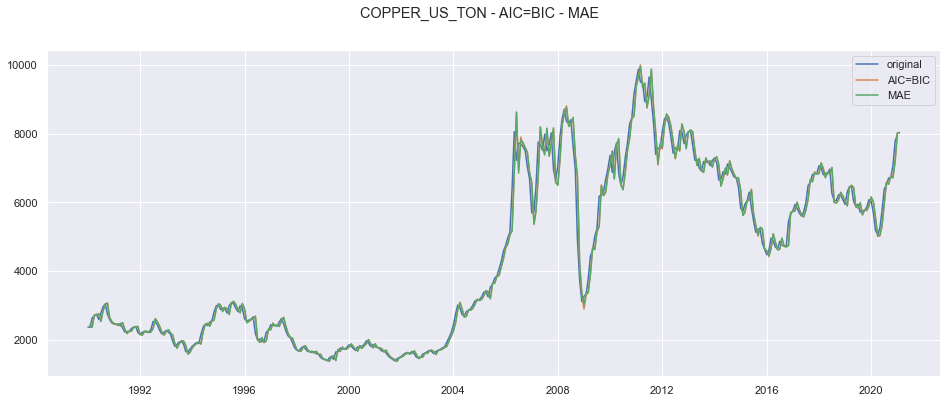

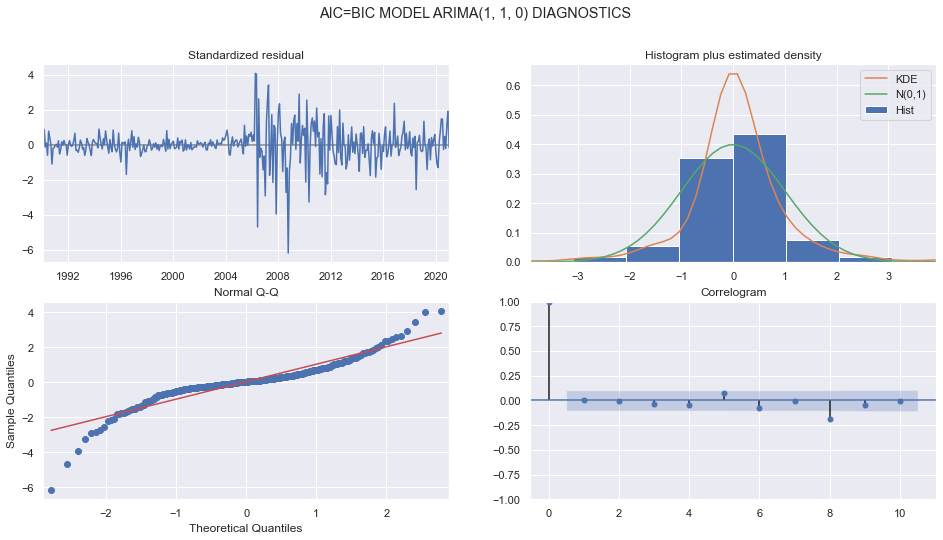

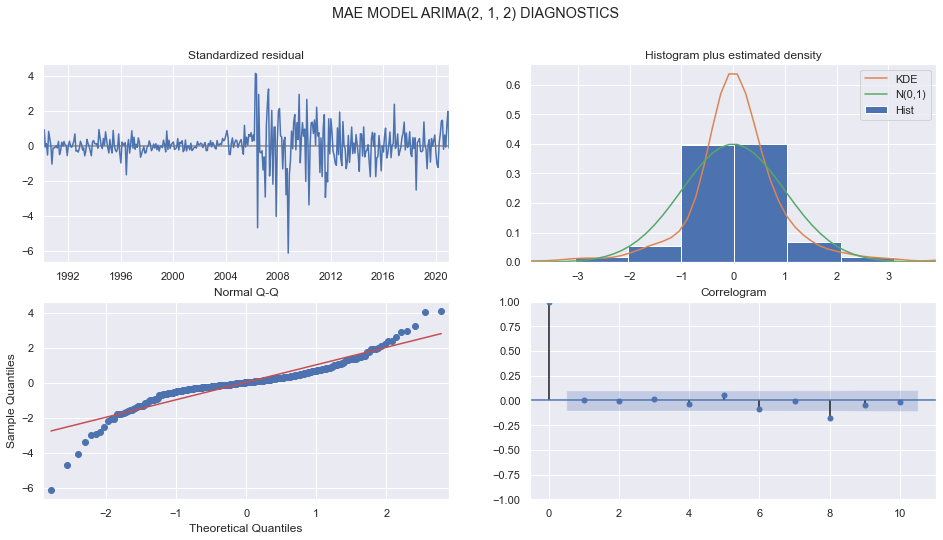

In [81]:
ic_order = (1,1,0)

mae_order = (2,1,2)

model_ic = ARIMA(df.COPPER_USD_TON, order=ic_order)
results_ic = model_ic.fit()

model_mae = ARIMA(df.COPPER_USD_TON, order=mae_order)
results_mae = model_mae.fit()


print(f"ARIMA{ic_order} MAE: {mae(results_ic.resid)}")
print(f"ARIMA{ic_order} MAPE: {mape(df.COPPER_USD_TON[1:], results_ic.fittedvalues)}")

print(f"ARIMA{mae_order} MAE: {mae(results_mae.resid)}")
print(f"ARIMA{mae_order} MAPE: {mape(df.COPPER_USD_TON[1:], results_mae.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(df.COPPER_USD_TON, label='original')
plt.plot(results_ic.predict(start=0, end=len(df.COPPER_USD_TON))[1:], label='AIC=BIC')
plt.plot(results_mae.predict(start=0, end=len(df.COPPER_USD_TON))[1:], label='MAE')

fig.suptitle(f"COPPER_US_TON - AIC=BIC - MAE")

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC=BIC MODEL ARIMA{ic_order} DIAGNOSTICS")

results_ic.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_diff_aic.resid,  lags=[10], return_df=True))

fig2 = plt.figure(figsize=(16,8))
fig2.suptitle(f"MAE MODEL ARIMA{mae_order} DIAGNOSTICS")

results_mae.plot_diagnostics(fig=fig2)
#print(acorr_ljungbox(results_diff_bic.resid,  lags=[10], return_df=True))
#plt.show()

fig.savefig('cpr_ts_models.png')
fig1.savefig('cpr_aic-bic_diagnostics.png')
fig2.savefig('cpr_mae_diagnostics.png')

In [70]:
Fig = go.Figure()

Fig.add_trace(go.Scatter(x=cpr_ic_result.resid.index, y=cpr_ic_result.resid))


# COPPER FORECASTS

In [82]:
def split_train_test(ts, size):
    
    train, test = ts[:size], ts[size:]
    
    return train, test   

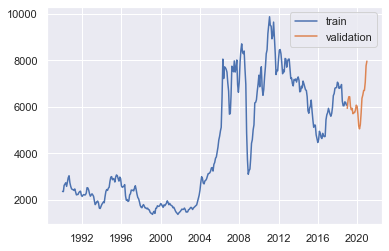

In [177]:
size = len(df.COPPER_USD_TON) - 25 # Entire dataset less one year

cpr_train, cpr_val = split_train_test(df.COPPER_USD_TON, size)

plt.plot(cpr_train, label='train')
plt.plot(cpr_val, label='validation')

plt.legend(loc='best')
plt.show()

In [113]:
trn_best, trn_models = gridsearch_ARIMA(cpr_train, (2,1,2), True)

trn_best

ARIMA(0, 0, 0) - AIC:6428.127068222224 BIC:6435.831473181773 MAE:2260.140682455604 RMSE: 0.01711193920596872
ARIMA(0, 0, 1) - AIC:6029.682931927791 BIC:6041.239539367115 MAE:1204.138524613333 RMSE: 5.8273688308999505
ARIMA(0, 0, 2) - AIC:5784.714695777472 BIC:5800.12350569657 MAE:794.9545015204685 RMSE: 3.9829071195493886
ARIMA(0, 1, 0) - AIC:4991.704284597461 BIC:4995.553609377408 MAE:201.73747126436783 RMSE: 17.457816091954026
ARIMA(0, 1, 1) - AIC:4956.397489660986 BIC:4964.09613922088 MAE:191.66511444611336 RMSE: 14.739596531835685
ARIMA(0, 1, 2) - AIC:4954.6783691844985 BIC:4966.226343524339 MAE:190.82485414820718 RMSE: 13.85931838438612
ARIMA(1, 0, 0) - AIC:5012.236844800977 BIC:5023.793452240301 MAE:200.1439314661307 RMSE: 5.211453265703315
ARIMA(1, 0, 1) - AIC:4975.972967313949 BIC:4991.381777233047 MAE:190.75951057116984 RMSE: 2.6277393828734907
ARIMA(1, 0, 2) - AIC:4973.812751227183 BIC:4993.073763626056 MAE:189.9591537576667 RMSE: 1.7804565404989596
ARIMA(1, 1, 0) - AIC:4952.

ARIMA(p,d,q) metric_value
AIC     (1, 1, 0)      4952.98
BIC     (1, 1, 0)      4960.68
MAE     (1, 0, 2)      189.959
RMSE    (0, 0, 0)    0.0171119

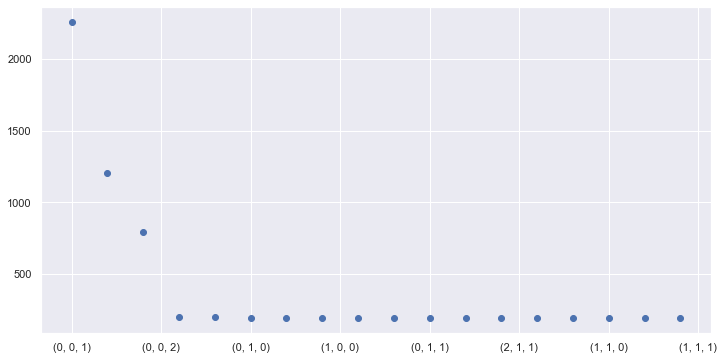

order          aic          bic          mae       rmse
0   (0, 0, 0)  6428.127068  6435.831473  2260.140682   0.017112
1   (0, 0, 1)  6029.682932  6041.239539  1204.138525   5.827369
2   (0, 0, 2)  5784.714696  5800.123506   794.954502   3.982907
3   (0, 1, 0)  4991.704285  4995.553609   201.737471  17.457816
6   (1, 0, 0)  5012.236845  5023.793452   200.143931   5.211453
4   (0, 1, 1)  4956.397490  4964.096139   191.665114  14.739597
16  (2, 1, 1)  4954.196037  4969.593336   191.658352  18.271797
9   (1, 1, 0)  4952.979447  4960.678097   191.111874  13.591150
10  (1, 1, 1)  4954.924437  4966.472411   191.082839  13.687213
15  (2, 1, 0)  4954.897350  4966.445324   191.072987  13.713529
17  (2, 1, 2)  4958.397515  4977.644139   190.894052  13.995140
11  (1, 1, 2)  4956.626359  4972.023658   190.869172  13.779876
5   (0, 1, 2)  4954.678369  4966.226344   190.824854  13.859318
7   (1, 0, 1)  4975.972967  4991.381777   190.759511   2.627739
12  (2, 0, 0)  4971.966294  4987.375104   190.198255   1.495149
13  (2, 0, 1)  4973.949899  4993.210911   190.175926   1.550434
14  (2, 0, 2)  4975.737649  4998.850864   189.967528   1.635943
8   (1, 0, 2)  4973.812751  4993.073764   189.959154   1.780457

In [114]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.scatter(
    x=trn_models.sort_values('mae', ascending=False).reset_index().index,
    y=trn_models.sort_values('mae', ascending=False).reset_index().mae
)

ax1.set_xticklabels(trn_models.sort_values('mae', ascending=False).reset_index().order.values)

plt.show()

trn_models.sort_values('mae', ascending=False)

ARIMA(1, 1, 0) MAE: 191.1118738992945
ARIMA(1, 1, 0) MAPE: 4.1312807801523865
ARIMA(0, 1, 2) MAE: 190.82485414820718
ARIMA(0, 1, 2) MAPE: 4.122931599346134


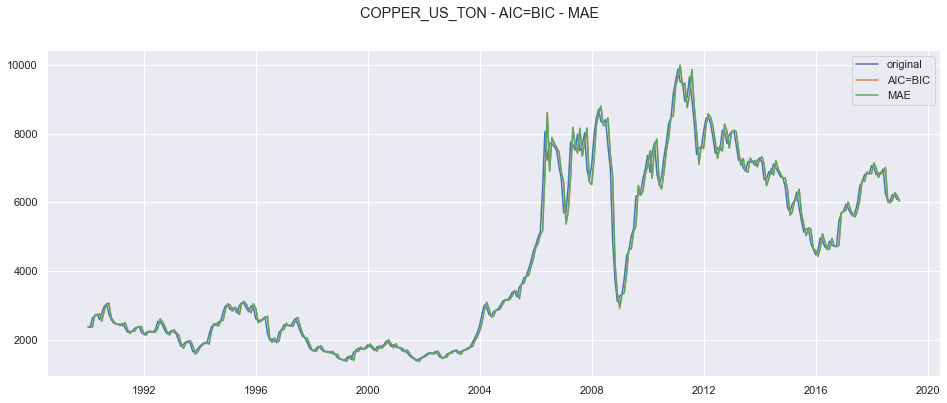

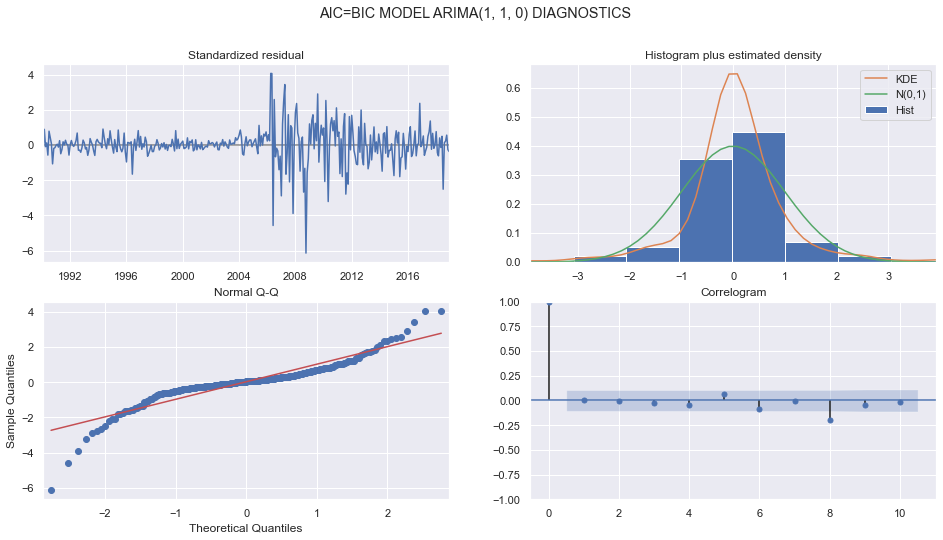

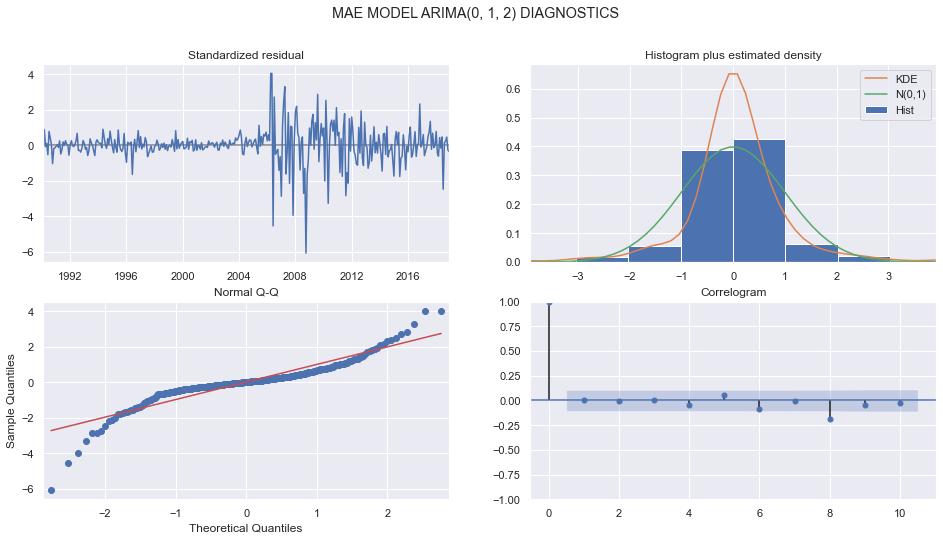

In [115]:
ic_order = (1,1,0)

mae_order = (0,1,2)

model_ic = ARIMA(cpr_train, order=ic_order)
results_ic = model_ic.fit()

model_mae = ARIMA(cpr_train, order=mae_order)
results_mae = model_mae.fit()


print(f"ARIMA{ic_order} MAE: {mae(results_ic.resid)}")
print(f"ARIMA{ic_order} MAPE: {mape(df.COPPER_USD_TON[1:], results_ic.fittedvalues)}")

print(f"ARIMA{mae_order} MAE: {mae(results_mae.resid)}")
print(f"ARIMA{mae_order} MAPE: {mape(df.COPPER_USD_TON[1:], results_mae.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(cpr_train, label='original')
plt.plot(results_ic.predict(start=0, end=len(cpr_train))[1:], label='AIC=BIC')
plt.plot(results_mae.predict(start=0, end=len(cpr_train))[1:], label='MAE')

fig.suptitle(f"COPPER_US_TON - AIC=BIC - MAE")

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC=BIC MODEL ARIMA{ic_order} DIAGNOSTICS")

results_ic.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_diff_aic.resid,  lags=[10], return_df=True))

fig2 = plt.figure(figsize=(16,8))
fig2.suptitle(f"MAE MODEL ARIMA{mae_order} DIAGNOSTICS")

results_mae.plot_diagnostics(fig=fig2)
#print(acorr_ljungbox(results_diff_bic.resid,  lags=[10], return_df=True))
#plt.show()

fig.savefig('cprTrain_ts_models.png')
fig1.savefig('cprTrain_aic-bic_diagnostics.png')
fig2.savefig('cprTrain_mae_diagnostics.png')

In [239]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math 

def out_forecast(train, test, model_order, alpha=.05):
    """
    Helper function to generate out-of-sample forecasts
    using ARIMA.
    """
    
    model = ARIMA(train, order=model_order)
    result = model.fit()
    
    pred = result.get_forecast(len(test))
    pred = pred.summary_frame(alpha=alpha)
    
    result.test = test
    result.prediction = pred
    
    mse = mean_squared_error(test, pred['mean'])
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(test, pred['mean'])
    mape = np.mean(np.abs(test-pred['mean'])/np.abs(test))*100
    r2 = r2_score(test, pred['mean'])
    
    metrics = {"RMSE": rmse, "MAE": mae, "MAPE": mape, "r2_score": r2}
    
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)
    print('Test R2: %.3f' % r2)    
    
    
    return result, metrics


def one_step_forecast(train, test, order, verbose=False):

    predictions = list()
    pred_ci = list()

    history = [x for x in train]

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.get_forecast()
        yhat = output.predicted_mean[0]
        l_ci = output.conf_int()[0][0]
        u_ci = output.conf_int()[0][1]
        pred_ci.append((l_ci,u_ci))
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
        if verbose:
            print('ARIMA%s: predicted=%f, expected=%f' % (order, yhat, obs))

    pred_ci = pd.DataFrame(pred_ci, columns=['l_ci','u_ci'])

    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(test, predictions)
    mape = np.mean(np.abs(test-predictions)/np.abs(test))*100
    r2 = r2_score(test, predictions)
    
    metrics = {"RMSE": rmse, "MAE": mae, "MAPE": mape, "r2_score": r2}
    
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)
    print('Test R2: %.3f' % r2)
    
    return predictions, pred_ci, metrics

## OUT OF SAMPLE FORECASTS

### MODEL AIC=BIC: ARIMA(1,1,0)

Test MSE: 498672.110
Test RMSE: 706.167
Test MAE: 505.640
Test MAPE: 7.877
Test R2: -0.048


(1, 1, 0)
RMSE      706.167197
MAE       505.639876
MAPE        7.877110
r2_score   -0.048472

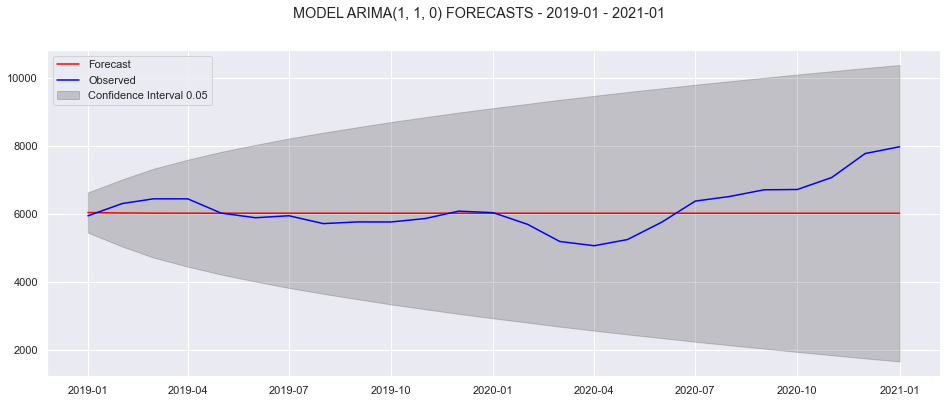

In [241]:
model_order = (1,1,0)
alpha = 0.05

cpr_model, metrics = out_forecast(cpr_train, cpr_val, (1,1,0), alpha)
cpr_fcast = cpr_model.prediction

# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

axs.fill_between(cpr_fcast.index,
                cpr_fcast['mean_ci_lower'],
                cpr_fcast['mean_ci_upper'], color='k', alpha=.2, label=f'Confidence Interval {alpha}')

plt.plot(cpr_fcast['mean'], color='red', label='Forecast')
plt.plot(cpr_val, color='blue', label='Observed')

fig.suptitle(f"MODEL ARIMA{model_order} FORECASTS - {cpr_val.index[0].strftime('%Y-%m')} - {cpr_val.index[-1].strftime('%Y-%m')}")
plt.legend(loc='upper left')

fig.savefig('cprFcast_IC_ConfInter.png')

#plt.plot(cpr_train, color='blue')
#plt.show() 

pd.DataFrame(metrics, index=[model_order]).T

### MODEL MAE: ARIMA(0,1,2)

Test MSE: 498272.161
Test RMSE: 705.884
Test MAE: 505.647
Test MAPE: 7.879
Test R2: -0.048


(0, 1, 2)
RMSE      705.883957
MAE       505.647063
MAPE        7.879402
r2_score   -0.047631

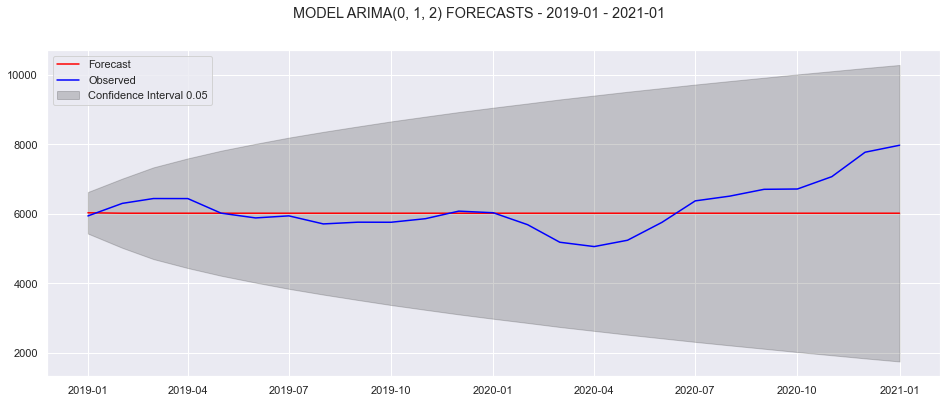

In [243]:
model_order = (0,1,2)
alpha = 0.05

cpr_model, metrics = out_forecast(cpr_train, cpr_val, model_order, alpha)
cpr_fcast = cpr_model.prediction

# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

axs.fill_between(cpr_fcast.index,
                cpr_fcast['mean_ci_lower'],
                cpr_fcast['mean_ci_upper'], color='k', alpha=.2, label=f'Confidence Interval {alpha}')

plt.plot(cpr_fcast['mean'], color='red', label='Forecast')
plt.plot(cpr_val, color='blue', label='Observed')

fig.suptitle(f"MODEL ARIMA{model_order} FORECASTS - {cpr_val.index[0].strftime('%Y-%m')} - {cpr_val.index[-1].strftime('%Y-%m')}")
plt.legend(loc='upper left')

fig.savefig('cprFcast_MAE_ConfInter.png')

#plt.plot(cpr_train, color='blue')
#plt.show() 

pd.DataFrame(metrics, index=[model_order]).T

## ONE STEP AHEAD FORECASTS

### MODEL AIC=BIC: ARIMA(1,1,0)

Test MSE: 68698.565
Test RMSE: 262.104
Test MAE: 201.778
Test MAPE: 3.286
Test R2: 0.856


(1, 1, 0)
RMSE      262.104111
MAE       201.777601
MAPE        3.285974
r2_score    0.855559

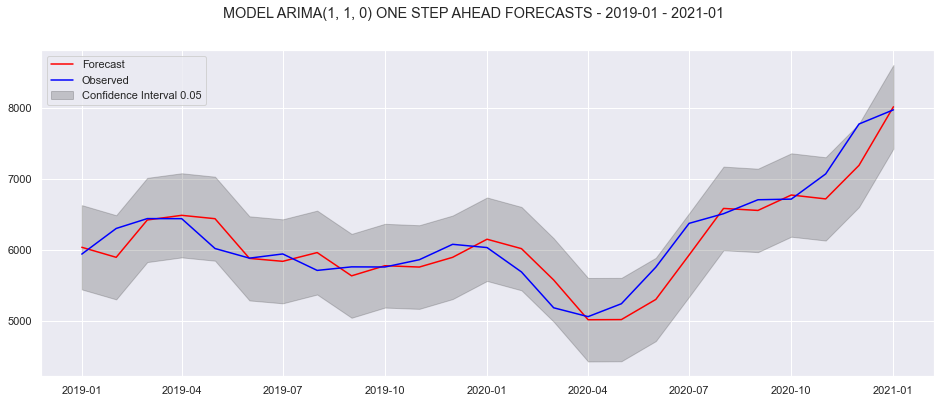

In [237]:
model_order = (1,1,0)
alpha = 0.05

predictions, pred_ci, metrics = one_step_forecast(cpr_train, cpr_val, model_order)

stp_fcast = pd.DataFrame(cpr_val)
stp_fcast['pred'] = predictions

stp_fcast['mean_ci_lower'], stp_fcast['mean_ci_upper'] = pred_ci.iloc[:, 0].values, pred_ci.iloc[:, 1].values

# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 6))



axs.fill_between(stp_fcast.index,
                stp_fcast['mean_ci_lower'],
                stp_fcast['mean_ci_upper'], color='k', alpha=.2, label=f'Confidence Interval {alpha}')

plt.plot(stp_fcast['pred'], color='red', label='Forecast')
plt.plot(stp_fcast['COPPER_USD_TON'], color='blue', label='Observed')
plt.legend(loc='upper left')
fig.suptitle(f"MODEL ARIMA{model_order} ONE STEP AHEAD FORECASTS - {cpr_val.index[0].strftime('%Y-%m')} - {cpr_val.index[-1].strftime('%Y-%m')}")

fig.savefig('cprOneStpFcast_IC_ConfInter.png')

pd.DataFrame(metrics, index=[model_order]).T

### MODEL MAE: ARIMA(0,1,2)

Test MSE: 67580.717
Test RMSE: 259.963
Test MAE: 199.567
Test MAPE: 3.246
Test R2: 0.858


(0, 1, 2)
RMSE      259.962915
MAE       199.566729
MAPE        3.245613
r2_score    0.857910

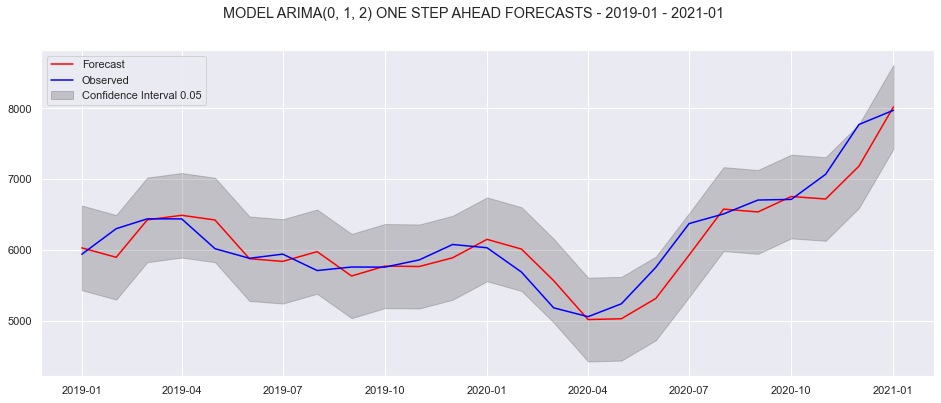

In [236]:
model_order = (0,1,2)
alpha = 0.05

predictions, pred_ci, metrics = one_step_forecast(cpr_train, cpr_val, model_order)

stp_fcast = pd.DataFrame(cpr_val)
stp_fcast['pred'] = predictions

stp_fcast['mean_ci_lower'], stp_fcast['mean_ci_upper'] = pred_ci.iloc[:, 0].values, pred_ci.iloc[:, 1].values

# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 6))



axs.fill_between(stp_fcast.index,
                stp_fcast['mean_ci_lower'],
                stp_fcast['mean_ci_upper'], color='k', alpha=.2, label=f'Confidence Interval {alpha}')

plt.plot(stp_fcast['pred'], color='red', label='Forecast')
plt.plot(stp_fcast['COPPER_USD_TON'], color='blue', label='Observed')
plt.legend(loc='upper left')
fig.suptitle(f"MODEL ARIMA{model_order} ONE STEP AHEAD FORECASTS - {cpr_val.index[0].strftime('%Y-%m')} - {cpr_val.index[-1].strftime('%Y-%m')}")

fig.savefig('cprOneStpFcast_MAE_ConfInter.png')

pd.DataFrame(metrics, index=[model_order]).T